# Stockformer Demo

In [1]:
import sys
# if not 'Informer2020' in sys.path:
#     sys.path += ['Informer2020']

## Experiments: Train and Test

In [2]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils.ipynb_helpers import args_from_setting, setting_from_args, handle_gpu, read_data

In [20]:
args = dotdict()
args.des = 'full_1h'

args.model = 'stockformer' # 'stockformer'

args.data = 'custom' # data
args.checkpoints = './checkpoints' # location of model checkpoints
args.root_path = './data/ETT/' # root path of data file

args.data_path = 'full_1h.csv' # data file
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h

args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'XOM_pctchange' # target feature in S or MS task


args.seq_len = 16 # input sequence length of Informer encoder
args.label_len = 1 # start token length of Informer decoder
args.pred_len = 1 # prediction sequence length

#["XOM_close", "BP_close", "CVX_close", "WTI_close"]
#["XOM_open", "XOM_high", "XOM_low", "XOM_close", "XOM_volume", "XOM_pctchange", "XOM_shortsma"]
args.cols = ["XOM_pctchange", #"XOM_open", "XOM_close", , "XOM_shortsma", 
                'CVX_pctchange', 'COP_pctchange', 'BP_pctchange', 'PBR_pctchange', 
                'WTI_pctchange', 'EOG_pctchange', 'ENB_pctchange', 'SLB_pctchange',
                ]#'C:USDSAR_pctchange'

args.enc_in = len(args.cols) # encoder input size
# args.dec_in = len(args.cols) # decoder input size # TODO: Remove
args.c_out = 1 if args.features in ["S", "MS"] else args.dec_in # output size


args.d_model = 128 # dimension of model; this is also the dimension of the token embeddings
args.n_heads = 8 # num of attention heads
args.e_layers = 12 # num of encoder layers
# args.d_layers = 4 # num of decoder layers # TODO: Remove
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.embed = None#'timeF' # time features encoding, options:[timeF, fixed, learned, None]
args.activation = 'gelu' # activation

args.attn = 'full' # attention used in encoder, options:[prob, full]
args.factor = 5 # probsparse attn factor; doesn't matter unless args.attn==prob
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in encoder
args.mix = False # whether to use mixed attention
args.padding = 0 # TODO: Remove

args.batch_size = 256 #64
args.learning_rate = 0.0001
args.loss = 'stock_lpp' # What loss function to use: ["mse", "stock_lpp", "stock_lppws", "stock_tanh"]
args.lradj = "type3"#"type3" # What learning rate scheduler to use: ["type3", None, "type1"]
args.train_epochs = 50
args.patience = 30 # For early stopping

args.use_amp = False # whether to use automatic mixed precision training
args.num_workers = 0
args.itr = 1 # number of runs

args.scale = True # whether to scale to mean 0, var 1
args.inverse = True # whether to invert that scale before loss is calculated, lets keep this at False

# This is for debugging to overfit
# When True, patience doesn't matter at all and the model-state that is saved is the one after the last epoch
# When False, the model-state that is saved is the one with the highest validation-loss and we can early stop with patience
args.no_early_stop = False 


# Control data split from args, either a date string like "2000-01-30" or None (for default)
args.date_start = "2012-01-01" # Train data starts on this date, default is to go back as far as possible
args.date_end = "2020-01-01" # Train data starts on this date, default is to go back as far as possible
args.date_test = "2019-06-01" # Test data is data after this date, default is to use ~20% of the data as test data



#args.load_model_path = "stockformer_custom_ftMS_sl16_ll4_pl1_ei12_di12_co1_iFalse_dm512_nh8_el12_dl4_df2048_atfull_fc5_ebtimeF_dtFalse_mxFalse_pretrain_full_1h_0/checkpoint-pretrain.pth"

# Code to handle gpu
# None to use all available GPUs
# False for not using GPUs, 
# 0 for using cuda:0, 
# "0,1" for using both cuda:0 and cuda:1
handle_gpu(args, "0,1,2,3")

# TODO: Figure out what this is for
args.detail_freq = args.freq
args.freq = args.freq[-1:]


print('Args in experiment:')
print(args)
Exp = Exp_Informer


# # Generate config
# import json
# with open("configs/placeholder.json", "w") as f:
#     json.dump(args, f, indent=4)

Args in experiment:
{'des': 'full_1h', 'model': 'stockformer', 'data': 'custom', 'checkpoints': './checkpoints', 'root_path': './data/ETT/', 'data_path': 'full_1h.csv', 'freq': 'h', 'features': 'MS', 'target': 'XOM_pctchange', 'seq_len': 16, 'label_len': 1, 'pred_len': 1, 'cols': ['XOM_pctchange', 'CVX_pctchange', 'COP_pctchange', 'BP_pctchange', 'PBR_pctchange', 'WTI_pctchange', 'EOG_pctchange', 'ENB_pctchange', 'SLB_pctchange'], 'enc_in': 9, 'c_out': 1, 'd_model': 128, 'n_heads': 8, 'e_layers': 12, 'd_ff': 2048, 'dropout': 0.05, 'embed': None, 'activation': 'gelu', 'attn': 'full', 'factor': 5, 'distil': False, 'output_attention': False, 'mix': False, 'padding': 0, 'batch_size': 256, 'learning_rate': 0.0001, 'loss': 'stock_lpp', 'lradj': 'type3', 'train_epochs': 50, 'patience': 30, 'use_amp': False, 'num_workers': 0, 'itr': 1, 'scale': True, 'inverse': True, 'no_early_stop': False, 'date_start': '2012-01-01', 'date_end': '2020-01-01', 'date_test': '2019-06-01', 'use_gpu': True, 'devic

### Train & Test *args.itr* models

In [21]:
exp = None
setting = None
for ii in range(args.itr):
    # setting record of experiments
    setting = setting_from_args(args, ii)
    
    # set experiments
    exp = Exp(args)
    
    # train
    print(f">>>>>>>start training : {setting}>>>>>>>>>>>>>>>>>>>>>>>>>>")
    exp.train(setting)

    # test
    print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
    exp.test(setting, flag="test", inverse=True)
    exp.test(setting, flag="val", inverse=True)
    exp.test(setting, flag="train", inverse=True)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : stockformer_custom_ftMS_sl16_ll1_pl1_ei9_diNone_co1_iTrue_dm128_nh8_el12_dlNone_df2048_atfull_fc5_ebNone_dtFalse_mxFalse_full_1h_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 7478
val 1072
test 2141
Epoch: 1 cost time: 4.420746088027954
Epoch: 1, Steps: 29 | Train Loss: -0.0080084 Vali Loss: 0.0468118 Test Loss: 0.0062543
Validation loss decreased (inf --> 0.046812).  Saving model ...
Epoch: 2 cost time: 4.212884426116943
Epoch: 2, Steps: 29 | Train Loss: -0.0126766 Vali Loss: 0.0373275 Test Loss: 0.0062543
Validation loss decreased (0.046812 --> 0.037327).  Saving model ...
Epoch: 3 cost time: 4.242891550064087
Epoch: 3, Steps: 29 | Train Loss: -0.0098126 Vali Loss: 0.0424797 Test Loss: 0.0062543
EarlyStopping counter: 1 out of 30
Epoch: 4 cost time: 4.228948593139648
Epoch: 4, Steps: 29 | Train Loss: -0.0121917 Vali Loss: 0.0370374 Test Loss: 0.0062543
Validation loss decreased (0.037327 --> 0.037037).  Saving model ...
Epoch: 5 cost time: 4.28942179679870

In [ ]:
# exp.test(setting, flag="test")#, inverse=False)
# exp.test(setting, flag="val")#, inverse=False)
# exp.test(setting, flag="train")#, inverse=False)

## Prediction

In [15]:
# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

manual = False

if manual:
    setting = "stockformer_custom_ftMS_sl16_ll4_pl1_ei12_di12_co1_iFalse_dm512_nh8_el12_dl4_df2048_atfull_fc5_ebNone_dtFalse_mxFalse_full_1h_0"
    args = args_from_setting(setting, args)
    exp = Exp(args)

path = os.path.join(args.checkpoints, setting, "checkpoint.pth")

exp.predict(setting, True)

# the prediction will be saved in ./results/{setting}/real_prediction.npy
prediction = np.load(f"./results/{setting}/real_prediction.npy")

print(prediction.shape)

# plt.figure()
# plt.plot(prediction[0,:,-1])
# plt.show()

pred 1
(1, 1, 1)


## Visualization

In [16]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

tp_dict = {}
for flag in ["train", "val", "test"]:
    preds_path = f"./results/{setting}/pred_{flag}.npy"
    trues_path = f"./results/{setting}/true_{flag}.npy"
    dates_path = f"./results/{setting}/date_{flag}.npy"
    if os.path.exists(preds_path) and os.path.exists(trues_path) and os.path.exists(dates_path):
        tp_dict[flag] = (np.load(trues_path), np.load(preds_path), np.load(dates_path))
        # tp_dict[flag] = list(zip(*sorted(zip(*tp_dict[flag]), key=lambda x: x[-1])))
        s = np.argsort(tp_dict[flag][2], axis=None)
        tp_dict[flag] = list(map(lambda x: x[s], tp_dict[flag]))
        

print("Open true/pred data for:", list(tp_dict.keys()))

# [samples, pred_len, dimensions]
print(tp_dict["train"][0].shape, tp_dict["val"][0].shape, tp_dict["test"][0].shape, "\n\n")

for flag in tp_dict:
    trues, preds, dates = tp_dict[flag]
    print(f"{flag}\ttrues.shape: {trues.shape}, preds.shape: {preds.shape}, dates.shape: {preds.shape}")
    
    MSE = np.square(np.subtract(trues,preds)).mean() 
    RMSE = np.sqrt(MSE)
    print("against preds", MSE, RMSE)

    MSE = np.square(np.subtract(trues,np.zeros(preds.shape))).mean() 
    RMSE = np.sqrt(MSE)
    print("against 0s", MSE, RMSE)

Open true/pred data for: ['train', 'val', 'test']
(7424, 1, 1) (1024, 1, 1) (2048, 1, 1) 


train	trues.shape: (7424, 1, 1), preds.shape: (7424, 1, 1), dates.shape: (7424, 1, 1)
against preds 1.2142157e-05 0.0034845597
against 0s 9.878236542236264e-06 0.003142966201255792
val	trues.shape: (1024, 1, 1), preds.shape: (1024, 1, 1), dates.shape: (1024, 1, 1)
against preds 1.4099403e-05 0.0037549173
against 0s 1.194844451709953e-05 0.0034566522123435457
test	trues.shape: (2048, 1, 1), preds.shape: (2048, 1, 1), dates.shape: (2048, 1, 1)
against preds 1.4790425e-05 0.003845832
against 0s 1.2836622488723325e-05 0.003582823256696222


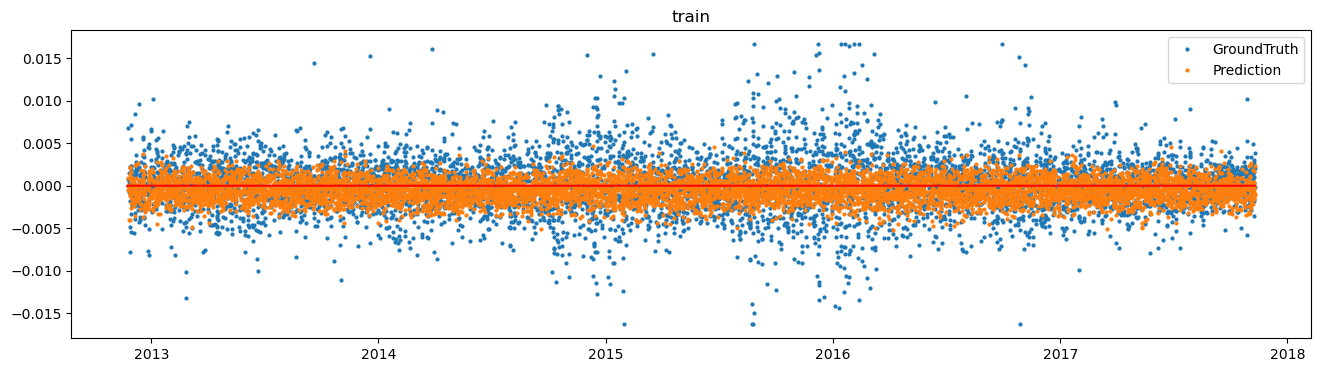

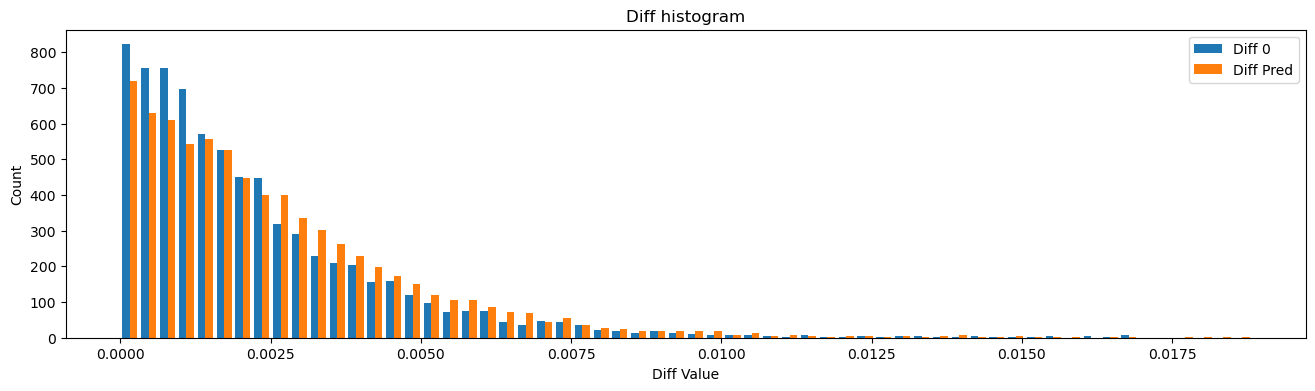

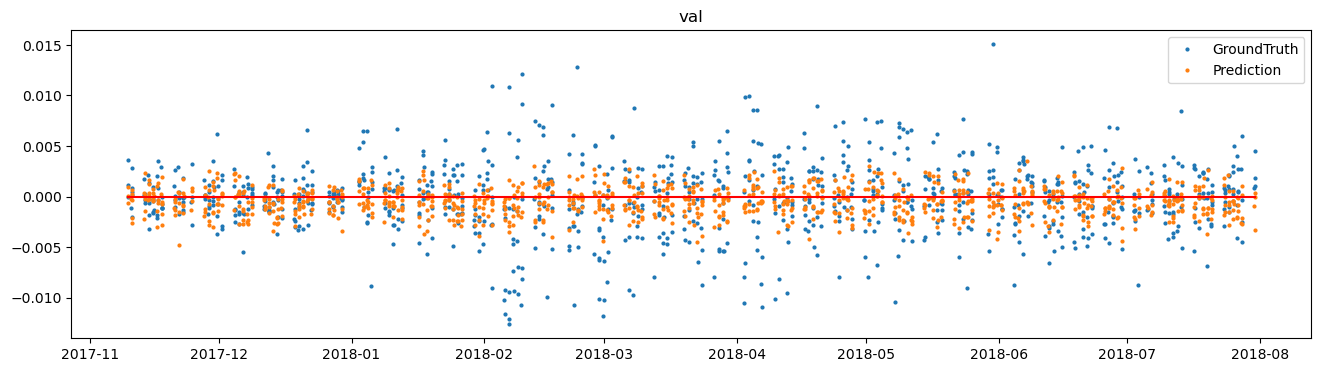

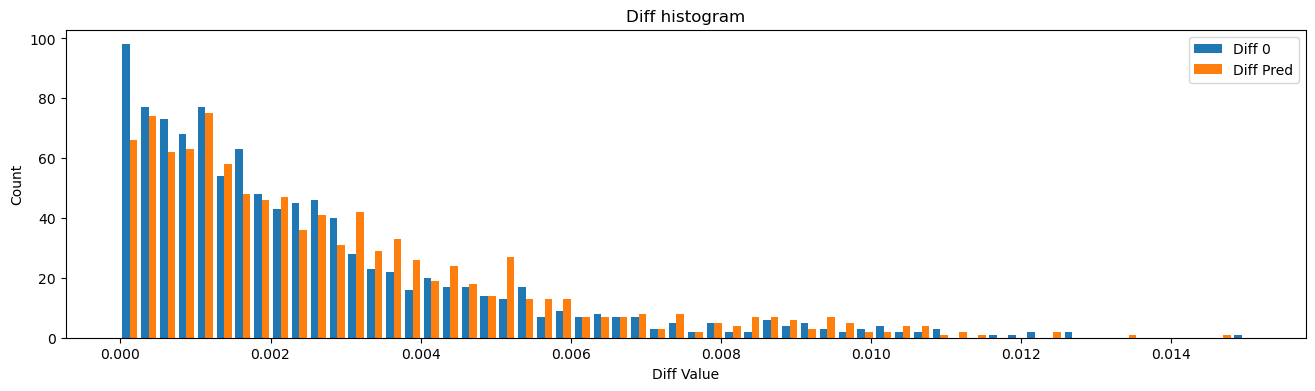

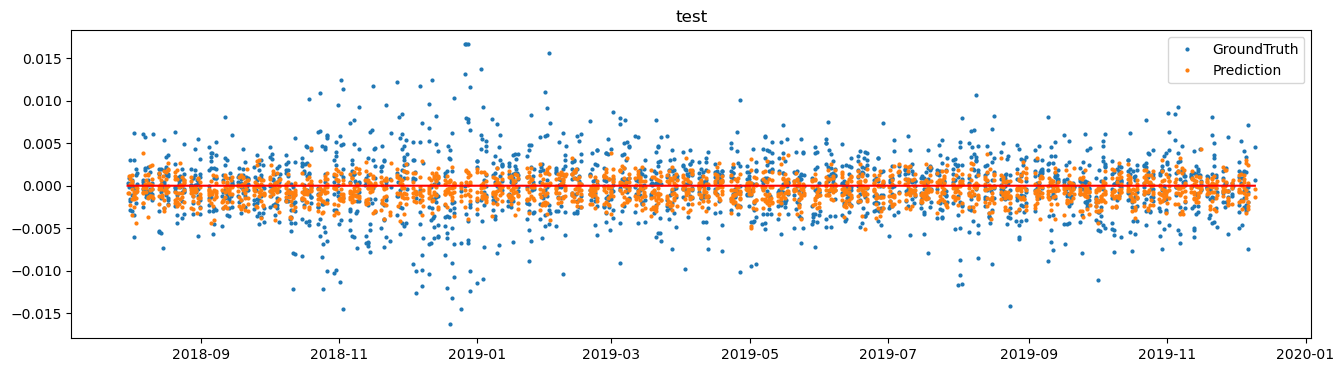

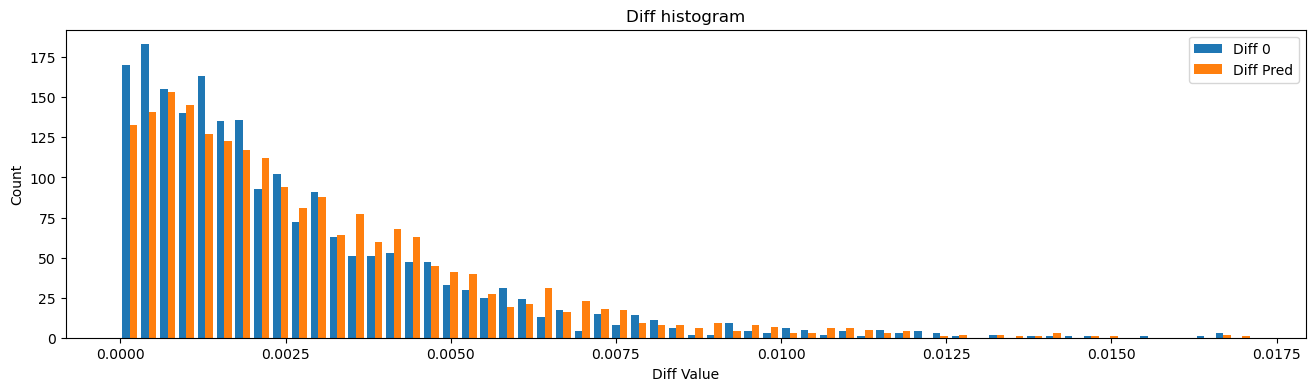

In [18]:
# draw OT prediction
for flag in tp_dict:
    trues, preds, dates = tp_dict[flag]
    true = trues[:,0,0]
    pred = preds[:,0,0]
    date = dates[:,0]
    plt.figure(num=flag, figsize=(16,4))
    plt.title(flag)
    plt.plot(date, true, label='GroundTruth', linestyle="",marker=".",markersize=4)
    plt.plot(date, pred, label='Prediction',linestyle="",marker=".",markersize=4)
    plt.plot(date, np.zeros(date.shape), color="red")
    # plt.scatter(range(trues.shape[0]), trues[:,0,0], marker='v', color='r', label='GroundTruth')
    # plt.scatter(range(trues.shape[0]), preds[:,0,0], marker='^', color='m', label='Prediction')

    plt.legend()
    plt.show()

    plt.figure(num=flag, figsize=(16,4))
    plt.title("Diff histogram")
    # plt.hist(np.abs(true), bins=len(true)//6, label='Diff 0', alpha=0.5)
    # plt.hist(np.abs(true - pred), bins=len(true)//6, label='Diff Pred', alpha=0.5)
    plt.hist([np.abs(true), np.abs(true - pred)], bins=60, label=['Diff 0', 'Diff Pred'])
    plt.xlabel("Diff Value")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

    # df = pd.concat([pd.DataFrame(a, columns=[f"{i}"]) for i, a in enumerate([np.abs(true - pred), np.abs(true)])], axis=1)

    # # plot the data
    # df.plot.hist(stacked=True, bins=len(true), density=True, figsize=(10, 6), grid=True)
    

## Basic back-test based on buying in predicted direction if prediction is above a threshold

In [19]:
max_tracker = (0, 0)

# Tracks results
tracker = {}

df = read_data(os.path.join(args.root_path, args.data_path))

# Get the percentile to check thresh until
percentile = [50, 0.0]
for flag in ["train"]: # tp_dict:
    _, preds, _ = tp_dict[flag]
    percentile[1] += np.percentile(np.abs(preds), percentile[0]) #np.median(np.abs(preds))
percentile[1] /= len(tp_dict)
print(f"{percentile[0]}'th percentile: {percentile[1]}")

ticker, field  = args.target.split("_")
assert field == "pctchange"

for thresh in np.linspace(0, .00025, 501):
    # print("thresh:", thresh)
    tracker[thresh] = {}
    track = {}
    for flag in tp_dict:
        trues, preds, dates = tp_dict[flag]
        # trues, preds = np.exp(trues), np.exp(preds)
        true = trues[:,0,0].copy()
        pred = preds[:,0,0].copy()
        date = pd.DatetimeIndex(dates[:,0], tz="UTC")

        df_flag = df.loc[date][np.abs(pred) >= thresh]
        
        # Filter by thresh. Note in log scale
        true_c_log = true[np.abs(pred) >= thresh]
        pred_c_log = pred[np.abs(pred) >= thresh]

        # Percent direction correct, ie up or down
        pct_dir_correct = np.sum(np.sign(true_c_log) == np.sign(pred_c_log))/len(true_c_log)

        true_c, pred_c = np.exp(true_c_log), np.exp(pred_c_log)

        # # Turn pct_change to price change
        # true_price_change = df_flag[ticker]["open"] * (true_c-1)
        # pred_price_change = df_flag[ticker]["open"] * (pred_c-1)
        # # Profit if you always bought one share with shorting
        # p_one_share_wshort = (true_price_change * np.sign(pred_price_change)).sum()
        # # Profit if you always bought one share without shorting
        # p_one_share = (true_price_change * np.sign(pred_price_change))[pred_price_change > 0].sum()


        # Important: Percent profit with & without shorting
        # pct_profit_wshort = ((true_c-1) * np.sign(pred_c-1) + 1).prod()
        pct_profit_wshort = np.exp((true_c_log * np.sign(pred_c_log)).sum())
        # pct_profit = ((true_c-1) * np.sign(pred_c-1) + 1)[pred_c > 1].prod()
        pct_profit = np.exp((true_c_log * np.sign(pred_c_log))[pred_c_log > 0].sum())

        # Important: percent profit with & without shorting with partial purchase
        pct_profit_tanh_wshort = np.exp((true_c_log * np.tanh(1000*pred_c_log)).sum())
        pct_profit_tanh = np.exp((true_c_log * np.tanh(1000*pred_c_log))[pred_c_log > 0].sum())

        # Optimal percent profit without shorting
        # pct_profit_opt = ((true_c-1) * np.sign(true_c-1) + 1)[true_c > 1].prod()
        pct_profit_opt = np.exp((true_c_log * np.sign(true_c_log))[true_c_log > 0].sum())

        # Tune threshhold based off of train's metric we care about
        tune_metric = pct_profit_tanh if args.loss == "stock_tanh" else pct_profit
        if tune_metric > max_tracker[0] and flag=='train':
            max_tracker = (tune_metric, thresh)

        # Save
        tracker[thresh][flag] = {
            "pct_profit": pct_profit, "pct_profit_wshort": pct_profit_wshort, 
            # "p_one_share": p_one_share, "p_one_share_wshort": p_one_share_wshort, 
            "pct_profit_tanh": pct_profit_tanh, "pct_profit_tanh_wshort": pct_profit_tanh_wshort,
            "pct_excluded": (len(pred) - len(pred_c_log[pred_c_log > 0]))/len(pred),
            "pct_excluded_wshort": (len(pred) - len(pred_c_log))/len(pred),
            "pct_dir_correct": pct_dir_correct,
            "pct_profit_opt": pct_profit_opt
        }


best_thresh = max_tracker[1]
print("best thresh:", best_thresh)
for k in tracker[best_thresh]:
    print(f"{k}\t", tracker[best_thresh][k])


50'th percentile: 0.0003311697510071099
best thresh: 6.5e-06
train	 {'pct_profit': 1.1744803, 'pct_profit_wshort': 0.8533285, 'pct_profit_tanh': 1.0145867, 'pct_profit_tanh_wshort': 0.7778336, 'pct_excluded': 0.6357758620689655, 'pct_excluded_wshort': 0.0028286637931034483, 'pct_dir_correct': 0.5024989868972038, 'pct_profit_opt': 5256.009}
val	 {'pct_profit': 0.98362327, 'pct_profit_wshort': 1.0807381, 'pct_profit_tanh': 0.977785, 'pct_profit_tanh_wshort': 0.99988246, 'pct_excluded': 0.6474609375, 'pct_excluded_wshort': 0.0048828125, 'pct_dir_correct': 0.5024533856722276, 'pct_profit_opt': 3.3809342}
test	 {'pct_profit': 1.0019284, 'pct_profit_wshort': 1.1424624, 'pct_profit_tanh': 1.0475818, 'pct_profit_tanh_wshort': 1.1546823, 'pct_excluded': 0.64453125, 'pct_excluded_wshort': 0.00390625, 'pct_dir_correct': 0.4857843137254902, 'pct_profit_opt': 13.377038}


## Attention Visualization

In [ ]:
args.output_attention = True

exp = Exp(args)

model = exp.model

path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

print(model.load_state_dict(torch.load(path)))

df = pd.read_csv(os.path.join(args.root_path, args.data_path))
df[args.cols].head()

In [ ]:
from data_provider.data_loader import Dataset_Custom
from torch.utils.data import DataLoader

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1
data_set = Data(args, flag=flag, freq=args.freq, timeenc=timeenc)

data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)


idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark, ds_index) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)



print(attn[0].shape, attn[1].shape) #, attn[2].shape



layers = [0,1]
distil = 'Distil' if args.distil else 'NoDistil'
for layer in layers:
    print("\n\n==========================")
    print("Showing attention layer", layer)
    print("==========================\n\n")
    for h in range(0, args.n_heads):
        plt.figure(figsize=[10,8])
        plt.title(f"Informer, {distil}, attn:{args.attn} layer:{layer} head:{h}")
        A = attn[layer][0,h].detach().cpu().numpy()
        ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
        plt.show()